In [128]:
from models_otimizador import otimizador
import pandas as pd
import json
import pulp
import numpy as np
import logging
import matplotlib.pyplot as plt

%load_ext autoreload
%reload_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Iniciando dados de entrada

Dataframe de entradas

In [129]:
# dataframe com index como datas de 2024-04-01 a 2024-12-31
ini = '2024-04-01'
fim = '2024-12-31'
entradas_df = pd.DataFrame({
    'data': pd.date_range(start='2024-04-01', end='2024-12-31', freq='D')})


entradas_df.head()

,data
0,2024-04-01
1,2024-04-02
2,2024-04-03
3,2024-04-04
4,2024-04-05


Json de entradas

In [130]:
entradas_json = {"indices":{}, "conjuntos":{},"parametros_modelo":{}, "parametros_por_contrato":{}}

# Leitura de dados externos

## Parâmetros de configurações

In [131]:
config = pd.read_csv('entradas/raw/tb_configuracoes.csv', index_col=0)
config.head()

,CH_CATEGORY,CH_TAG,CH_DESCRIPTION,CH_TITLE,NR_VALUE,CH_UNIT,CH_OBSERVATION
CH_ID_CONFIGURATION,,,,,,,
089f0f1d0e7e42919ad33f3e14a920f9,Default de Parâmetros de criação de cenários,TM_BOGCTE,"Tempo máximo, em segundos, de execução da simu...",Tempo máximo de execução para BOG constante (s),600,s,NaN
1c62d914038f46d1af487b895fa43f39,Composição da carga de GNL padrão,NC5,Percentual molar de n-pentano,n-C5,"0,01",%,NaN
1c870480b7e842168c4cc35eed7ecd8b,Parâmetros para simulações,MAX_INVENTORY,Nível máximo do inventário.,Inventário Máx.,165285,m³GNL,NaN
21ad3ca4b7e04b518edb65b1788c8d22,Default de Parâmetros de criação de cenários,K,Custo fixo de recebimento de carga devido à de...,Custo fixo da operação STS,500000,US$,NaN
257ee827771648c89c210c71d9758299,Parâmetros para simulações,GER_DIARIA_UTE_PSI,Capacidade máxima de geração da UTE PS-I,Geração Máx. UTE PS-I,1516,MW,NaN


In [132]:
config[config['CH_CATEGORY']=='Conversões']

,CH_CATEGORY,CH_TAG,CH_DESCRIPTION,CH_TITLE,NR_VALUE,CH_UNIT,CH_OBSERVATION
CH_ID_CONFIGURATION,,,,,,,
3184c351fdfb44be9f0d8f080ccc7686,Conversões,MWH_M3GNL,Conversão de MWh para kg. Média dos dados hist...,Conversão de m³GNL para MWh da UTE-PSI,"3,73",-,NaN
43021964a0ea4b589318ba24738a6fb6,Conversões,KG_SM3,Conversão de Sm³ para kg. Média dos dados hist...,Conversão de Sm³ para Kg,"0,723",-,NaN
5ccf4deb89934875bf6208a616c8981d,Conversões,MJ_KG,Conversão de kg para MJ. Média dos dados histó...,Conversão de Kg para MJ,"54,944",-,NaN
9093168cc74b4535a3e8648dbbb1703a,Conversões,KG_NM3,Conversão de Nm³ para kg. Média dos dados hist...,Conversão de Nm³ para Kg,"0,711",-,NaN
98cecd3df39349968248a6702394bfa5,Conversões,F3_M3,Parâmetro de conversão de m³ para ft³,Conversão de m³ para ft³,"35,147",-,NaN
cb4e32d7f2ab4553b41ef1d88cf4cba2,Conversões,KG_M3GNL,Conversão de m³ de GNL para kg. Média dos dado...,Conversão de m³GNL para Kg,"438,478",-,NaN
de83a7bce245424c8f30e662a98b9446,Conversões,MJ_MMBTU,Parâmetro de conversão de MMBTU para MJ (razão...,Conversão de MMBTU para MJ,"1055,056",-,NaN


In [133]:
MJ_MMBTU = config[config["CH_TAG"] == "MJ_MMBTU"]["NR_VALUE"].values[0]
# replace , for . 
MJ_MMBTU = float(str(MJ_MMBTU).replace(",","."))

KG_M3GNL = config[config["CH_TAG"] == "KG_M3GNL"]["NR_VALUE"].values[0]
# replace , for .
KG_M3GNL = float(str(KG_M3GNL).replace(",","."))

MJ_KG = config[config["CH_TAG"] == "MJ_KG"]["NR_VALUE"].values[0]
# replace , for .
MJ_KG = float(str(MJ_KG).replace(",","."))

M3GNL_MMBTU = (MJ_MMBTU / MJ_KG) * (1 / KG_M3GNL)

MWH_M3GNL = config[config["CH_TAG"] == "MWH_M3GNL"]["NR_VALUE"].values[0]
# replace , for . 
MWH_M3GNL = float(str(MWH_M3GNL).replace(",","."))

KG_NM3 = config[config["CH_TAG"] == "KG_NM3"]["NR_VALUE"].values[0]
# replace , for . 
KG_NM3 = float(str(KG_NM3).replace(",","."))



Valores default para os parâmetros de entrada do modelo

In [134]:
config.loc[config["CH_CATEGORY"]=="Default de Parâmetros de criação de cenários",["CH_TAG","NR_VALUE"]]

,CH_TAG,NR_VALUE
CH_ID_CONFIGURATION,,
089f0f1d0e7e42919ad33f3e14a920f9,TM_BOGCTE,600
21ad3ca4b7e04b518edb65b1788c8d22,K,500000
27420050b5fe47f0846103ac3579301e,S0,0
342d7c0d1b1143e6a0a420d285d1076b,Q2,150000
4eb11ad9adb6493b8d3b2209d3725141,DW,10
58932e6f511142598238ac4aa6928f8d,BOGCTE,1
69cb12c97a00477986d496eba041575f,BG,100
882beb72813c46b8b84b79f0a06b60c7,SMIN_FLEX,1
9ba53e52882d4059b2a3a124e57d7700,TM_BOGLEVEL,1200


## Dados de entrada de preço de GNL 

fonte: https://www.gov.br/mme/pt-br/assuntos/secretarias/petroleo-gas-natural-e-biocombustiveis/publicacoes-1/boletim-mensal-de-acompanhamento-da-industria-de-gas-natural/2024/12-boletim-de-acompanhamento-da-industria-de-gas-natural-dezembro-de-2024.pdf

Dados de jan a dez de 2024
- Spot LNG FOB Brazil  em US$/MMBtu: pag 15
- Petróleo Brent em US$/bbl: pag 15


In [135]:
spot_lng_fob_brazil = [8.35, 12.22, 7.93, 7.92, 27.62, 19.31, 13.51, 13.69, 13.64, 10.19, 9.40, 8.93]
brent_crude_oil = [80.23, 83.76, 85.45,90.05 ,81.75 ,82.25 ,85.15 ,80.36 ,74.02 ,75.63 ,74.35 ,73.86 ]

dolar_data = pd.read_csv('entradas/raw/USD_BRL Dados Históricos.csv',parse_dates=['Data'], dayfirst=True,index_col='Data')
# replace , for . and convert to float
dolar_data['Último'] = dolar_data['Último'].str.replace(',','.').astype(float)
dolar_data.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2024-12-31,6.1778,"6,1778","6,1778","6,1778",NaN,"0,00%"
2024-12-30,6.1778,"6,2030","6,2428","6,1518",NaN,"-0,30%"
2024-12-27,6.1964,"6,1834","6,2159","6,1693",NaN,"0,22%"
2024-12-26,6.1828,"6,1602","6,1982","6,1462",NaN,"-0,13%"
2024-12-25,6.1906,"6,1906","6,1906","6,1906",NaN,"0,00%"


In [136]:
# Criar dataframe com índice diário com datas de 2024-01-01 a 2024-12-31
date_range = pd.date_range(start='2024-01-01', end='2024-12-31', freq='D')
df_price = pd.DataFrame(index=date_range)
# Adicionar dados de entrada ao dataframe repetindo valores mensais para cada dia do mês
df_price['spot_lng_fob_brazil'] = np.repeat(spot_lng_fob_brazil, [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
df_price['brent_crude_oil'] = np.repeat(brent_crude_oil, [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])

# adicionar coluna com valor do dólar para cada dia a partir da coluna "último" do dataframe dolar_data
df_price['dolar_brl'] = dolar_data['Último'].resample('D').ffill().reindex(date_range)
df_price.reset_index(inplace=True)
df_price.head()

,index,spot_lng_fob_brazil,brent_crude_oil,dolar_brl
0,2024-01-01,8.35,80.23,4.8526
1,2024-01-02,8.35,80.23,4.9235
2,2024-01-03,8.35,80.23,4.9198
3,2024-01-04,8.35,80.23,4.8968
4,2024-01-05,8.35,80.23,4.8743


In [137]:
df_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   index                366 non-null    datetime64[ns]
 1   spot_lng_fob_brazil  366 non-null    float64       
 2   brent_crude_oil      366 non-null    float64       
 3   dolar_brl            366 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 11.6 KB


# Construção de parâmetros do modelo



## Lista de Símbolos

### Índices e conjuntos

| Símbolo | Descrição |
|---------|-----------|
| $t \in T$ | Index of time periods in the planning horizon |
| $i \in I$ | Index of downstream gas consumers |
| $j \in J$ | Index of LNG procurement contracts |
| $c \in C$ | Index of pricing tiers in SPA contracts |
| $m \in M$ | Index of take-or-pay (ToP) penalty tiers |
| $n \in N$ | Index of inventory intervals for BOG modeling |

### Parâmetros

- Operação da FSRU

| Símbolo | Descrição |
|---------|-----------|
| $\hat{S}_0$ | Initial LNG inventory level (m$^3$) |
| $\hat{S}^{up}$ | Maximum LNG storage capacity of the FSRU (m$^3$) |
| $\hat{S}^{idle}_{lo}$ | Minimum inventory level required during idle operation (m$^3$) |
| $\hat{S}^{prod}_{lo}$ | Minimum inventory level required during regasification (m$^3$) |
| $\hat{K}$ | Fixed cost associated with ship-to-ship unloading operation (R\$) |



- Demanda de GNL

| Símbolo | Descrição |
|---------|-----------|
| $\hat{V}^{d}_{i,t}$ | LNG demand of consumer $i$ in period $t$ (m$^3$) |
| $\hat{I}_t$ | Binary parameter indicating operating mode (1 = idle, 0 = production) |


-  Contratos de fornecimento de GNL

| Símbolo | Descrição |
|---------|-----------|
| $\hat{V}^{adp}_{j,t}$ | Scheduled LNG volume under the Annual Delivery Program (ADP) for contract $j$ in period $t$ (m$^3$) |
| $\hat{V}_{j}^{total}$ | Corresponds to the Annual Contract Quantity (ACQ) for contract $j$ |
| $\hat{P}^{spa,price}_{j,c}$ | LNG unit price associated with pricing tier $c$ of contract $j$ (R\$/m$^3$) |
| $\hat{P}^{spa,top}_{j,m}$ | Take-or-pay penalty associated with tier $m$ of contract $j$ (R\$/m$^3$) |
| $\hat{V}^{price,lo}_{j,c}$ | Lower accumulated volume threshold for pricing tier $c$ (m$^3$) |
| $\hat{V}^{price,up}_{j,c}$ | Upper accumulated volume threshold for pricing tier $c$ (m$^3$) |
| $\hat{V}^{top,lo}_{j,m}$ | Lower accumulated canceled volume threshold for ToP tier $m$ (m$^3$) |
| $\hat{V}^{top,up}_{j,m}$ | Upper accumulated canceled volume threshold for ToP tier $m$ (m$^3$) |
| $\hat{P}^{spot}_t$ | Spot LNG price in period $t$ (R\$/m$^3$) |
|$\hat{V}^{spot,lo}$ | Minimum spot volume |
|$\hat{V}^{spot,up}$ | Maximum spot volume |
| $\hat{P}^{dem}$ | Daily demurrage penalty cost (R\$) |
| $ER_t$ | Exchange rate (R\$/US\$) in period $t$ |


- Geração de BOG

| Símbolo | Descrição |
|---------|-----------|
| $\hat{V}^{bog,lo}_{n}$ | Lower inventory bound of BOG interval $n$ (m$^3$) |
| $\hat{V}^{bog,up}_{n}$ | Upper inventory bound of BOG interval $n$ (m$^3$) |
| $\hat{F}^{bog}_{n}$ | Boil-off rate associated with interval $n$ (-) |
| $\hat{V}^{prod}_{bog}$ | BOG generated during regasification (m$^3$/day) |

- Custo financeiro de imobilização de capital

| Símbolo | Descrição |
|---------|-----------|
| $\hat{R}$ | Interest rate used to represent capital cost (-) |
| $\hat{P}^{cap}$ | Reference LNG price for inventory capitalization (R\$/m$^3$) |




- Outros

| Símbolo | Descrição |
|---------|-----------|
| $\kappa$ | Energy-to-volume conversion factor (MMBtu per m$^3$ of LNG) |

| $\alpha_c$ | Slope coefficient of oil-indexed LNG pricing formula (-) |

### Variáveis

| Símbolo | Descrição |
|---------|-----------|
| $s_t$ | LNG inventory level at the end of period $t$ (m$^3$) |
| $x_t$ | Spot LNG volume procured in period $t$ (m$^3$) |
| $y_{j,t}$ | Binary variable indicating confirmation of SPA cargo $j$ in period $t$ |
| $y^{price}_{j,c,t}$ | Binary variable indicating activation of pricing tier $c$ for contract $j$ in period $t$ |
| $y^{top}_{j,m,t}$ | Binary variable indicating activation of take-or-pay tier $m$ for contract $j$ in period $t$ |
| $y^{bog}_{n,t}$ | Binary variable selecting BOG interval $n$ in period $t$ |
| $b_t$ | Boil-off gas volume generated in period $t$ (m$^3$) |
| $v_t$ | Virtual financial account balance associated with LNG inventory in period $t$ (R\$) |
| $c^{a}_{j,t}$ | Accumulated confirmed volume under contract $j$ up to period $t$ (m$^3$) |
| $c^{c}_{j,t}$ | Accumulated canceled volume under contract $j$ up to period $t$ (m$^3$) |



## Demanda de GNL



| Símbolo | Descrição |
|---------|-----------|
| $\hat{V}^{d}_{i,t}$ | LNG demand of consumer $i$ in period $t$ (m$^3$) |
| $\hat{I}_t$ | Binary parameter indicating operating mode (1 = idle, 0 = production) |

A demanda de GNL considera 2 consumidores distintos: o parque termoelétrico e uma distribuidora de gás

A demanda do parque termoelétrico deve considerar uma geração de 1,2 GW todos os dias entre julho e outubro do ano em questão  

Já a distribuidora contratou 1MM de nm³ de gás a serem entregues durante o mes de outubro

Cálculo da demanda diária dos consumidores

In [138]:
# 
termoeletrica = 1200 * 24 / MWH_M3GNL
print(f"Demanda termoelétrica: 1.2 GW -> {termoeletrica:.2f} m³ de GNL por dia")
termoeletrica = round(termoeletrica, 0)
print(f"Demanda termoelétrica: 1.2 GW -> {termoeletrica:.2f} m³ de GNL por dia")
# Conversào de 3MM de nm³ de GN para m³ de GNL
GN = 1e6
distribuidora = GN * KG_NM3 / KG_M3GNL
print(f"Demanda distribuidora: 1 MM Nm³ -> {distribuidora:.2f} m³ de GNL por dia")
distribuidora = round(distribuidora, 0)
print(f"Demanda distribuidora: 1 MM Nm³ -> {distribuidora:.2f} m³ de GNL por dia")
print(f"Demanda total: {termoeletrica + distribuidora:.2f} m³ de GNL por dia")

Demanda termoelétrica: 1.2 GW -> 7721.18 m³ de GNL por dia
Demanda termoelétrica: 1.2 GW -> 7721.00 m³ de GNL por dia
Demanda distribuidora: 1 MM Nm³ -> 1621.52 m³ de GNL por dia
Demanda distribuidora: 1 MM Nm³ -> 1622.00 m³ de GNL por dia
Demanda total: 9343.00 m³ de GNL por dia


In [139]:
MWH_M3GNL

3.73

In [140]:
MWH_M3GNL

3.73

Montagem do Parâmetro V_d

In [141]:
# Adicionando ao dataframe entradas a coluna de demanda termoelétrica  (V_d_0) com valor de 7721.18 para o período de julho a novembro de 2024
entradas_df.loc[(entradas_df['data'] >= '2024-06-01') & (entradas_df['data'] <= '2024-06-30'), 'V_d_0'] = termoeletrica
entradas_df.loc[(entradas_df['data'] >= '2024-09-01') & (entradas_df['data'] <= '2024-10-31'), 'V_d_0'] = termoeletrica

# Adicionando ao dataframe entradas a coluna de demanda distribuidora (V_d_1) com valor de 1621.52 durante o mes de outbro de 2024
entradas_df.loc[(entradas_df['data'] >= '2024-10-01') & (entradas_df['data'] <= '2024-10-31'), 'V_d_1'] = distribuidora
# entradas_df['V_d_1'] = distribuidora
entradas_df.fillna(0, inplace=True)

In [142]:
tempo

0     2024-04-01
1     2024-04-02
2     2024-04-03
3     2024-04-04
4     2024-04-05
         ...    
270   2024-12-27
271   2024-12-28
272   2024-12-29
273   2024-12-30
274   2024-12-31
Name: data, Length: 275, dtype: datetime64[ns]

In [143]:
entradas_df

,data,V_d_0,V_d_1
0,2024-04-01,0.0,0.0
1,2024-04-02,0.0,0.0
2,2024-04-03,0.0,0.0
3,2024-04-04,0.0,0.0
4,2024-04-05,0.0,0.0
...,...,...,...
270,2024-12-27,0.0,0.0
271,2024-12-28,0.0,0.0
272,2024-12-29,0.0,0.0
273,2024-12-30,0.0,0.0


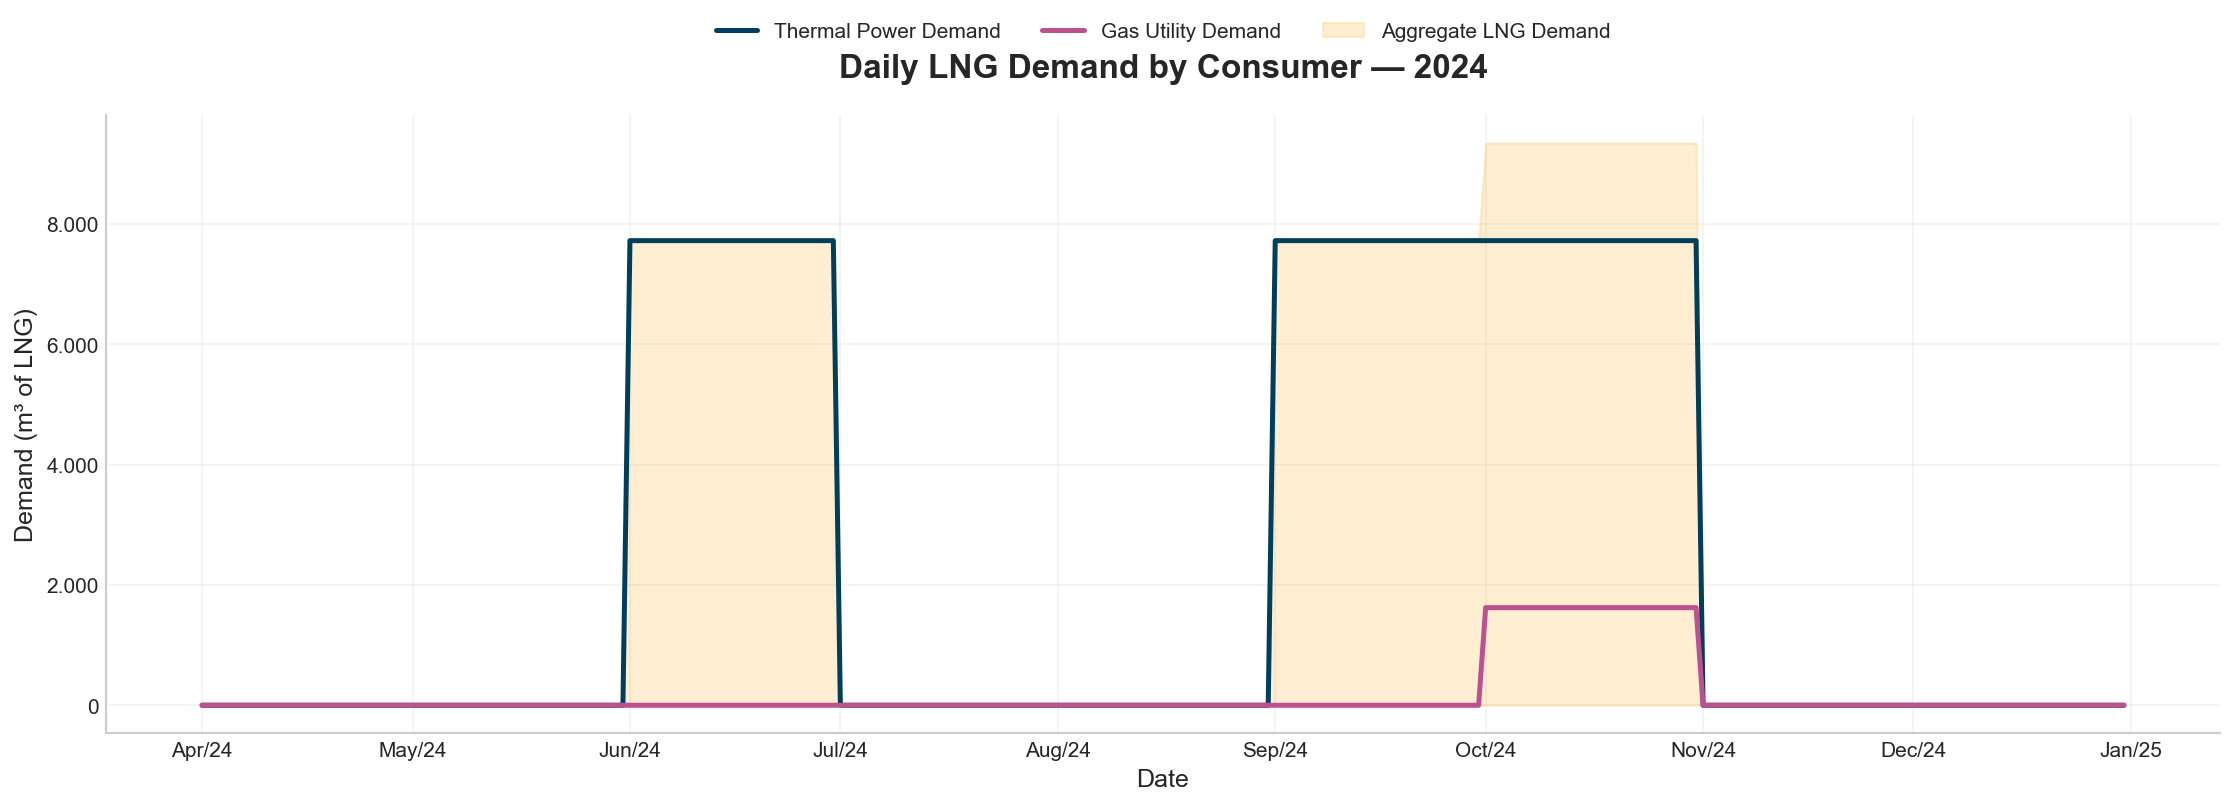

In [144]:
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(15,5.5), dpi=150)

# Prepare time series for visualization
tempo = pd.to_datetime(entradas_df['data'])
termo = entradas_df['V_d_0']
distrib = entradas_df['V_d_1']
total = termo + distrib

palette = {
    "thermo": "#003f5c",
    "utility": "#bc5090",
    "total": "#ffa600"
}

ax.plot(tempo, termo, label='Thermal Power Demand', color=palette["thermo"], linewidth=2.4)
ax.plot(tempo, distrib, label='Gas Utility Demand', color=palette["utility"], linewidth=2.4)
ax.fill_between(tempo, 0, total, color=palette["total"], alpha=0.18, label='Aggregate LNG Demand')

ax.set_title('Daily LNG Demand by Consumer — 2024', fontsize=16, pad=18, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Demand (m³ of LNG)', fontsize=12)

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b/%y'))
plt.setp(ax.get_xticklabels(), rotation=0, ha='center')
ax.yaxis.set_major_formatter(FuncFormatter(lambda val, _: f"{val:,.0f}".replace(',', '.')))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(alpha=0.25)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.18), ncol=3, frameon=False)
plt.savefig('saidas/visualizacao_demanda_2024.png', dpi=300)
plt.tight_layout()
plt.show()

# salvar em saidas/visualizacao_demanda_2024.png


Montagem do parametro I

In [145]:
# Soma dos valores das colunas V_d_0 e V_d_1 para obter a demanda total de GNL por dia
V_total = entradas_df['V_d_0'] + entradas_df['V_d_1']

# Adicionar ao entradas_df a coluna I que tem valor 0 caso V_total >0 e 1 caso V_total = 0
entradas_df['Idle'] = V_total.apply(lambda x: 0 if x > 0 else 1)

In [146]:
entradas_df[:50]

,data,V_d_0,V_d_1,Idle
0,2024-04-01,0.0,0.0,1
1,2024-04-02,0.0,0.0,1
2,2024-04-03,0.0,0.0,1
3,2024-04-04,0.0,0.0,1
4,2024-04-05,0.0,0.0,1
5,2024-04-06,0.0,0.0,1
6,2024-04-07,0.0,0.0,1
7,2024-04-08,0.0,0.0,1
8,2024-04-09,0.0,0.0,1
9,2024-04-10,0.0,0.0,1


## Operação da FSRU



| Símbolo | Descrição |
|---------|-----------|
| $\hat{S}_0$ | Initial LNG inventory level (m$^3$) |
| $\hat{S}^{up}$ | Maximum LNG storage capacity of the FSRU (m$^3$) |
| $\hat{S}^{idle}_{lo}$ | Minimum inventory level required during idle operation (m$^3$) |
| $\hat{S}^{prod}_{lo}$ | Minimum inventory level required during regasification (m$^3$) |
| $\hat{I}_t$ | Binary parameter indicating operating mode (1 = idle, 0 = production) |
| $\hat{K}$ | Fixed cost associated with ship-to-ship unloading operation (R\$) |

In [147]:
S_0 = 12000
S_up = 170000
S_idle_lo = 10000
S_prod_lo = 20000
K = 3000000

S0 -> S_0
S_MAX -> S_up  
S_MIN_IDLE -> S_idle_lo  
S_MIN_PROD -> S_prod_lo

In [148]:
entradas_json["parametros_modelo"].update({
    "S_0": S_0,
    "S_up": S_up,
    "S_idle_lo": S_idle_lo,
    "S_prod_lo": S_prod_lo,
    "K": K})

## Contratos de fornecimento de GNL


- Parâmetros SPA
  
| Símbolo | Descrição |
|---------|-----------|
| $\hat{V}^{adp}_{j,t}$ | Scheduled LNG volume under the Annual Delivery Program (ADP) for contract $j$ in period $t$ (m$^3$) |
| $\hat{V}_{j}^{total}$ | Corresponds to the Annual Contract Quantity (ACQ) for contract $j$ |
| $\hat{V}_{j}^{ac,0}$ | Initial value of the continuous variable $ca_{j,t}$ represents the accumulated volume of confirmed cargoes under contract $j$ up to period $t$|
| $\hat{V}^{price,lo}_{j,c}$ | Lower accumulated volume threshold for pricing tier $c$ (m$^3$) |
| $\hat{V}^{price,up}_{j,c}$ | Upper accumulated volume threshold for pricing tier $c$ (m$^3$) |
| $\hat{V}_{j}^{cc,0}$ | Initial value of the continuous variable $cc_{j,t}$ represents the accumulated volume of canceled cargoes under contract $j$ up to period $t$|
| $\hat{V}^{top,lo}_{j,m}$ | Lower accumulated canceled volume threshold for ToP tier $m$ (m$^3$) |
| $\hat{V}^{top,up}_{j,m}$ | Upper accumulated canceled volume threshold for ToP tier $m$ (m$^3$) |
| $\hat{P}^{spa,price}_{j,c,t}$ | LNG unit price associated with pricing tier $c$ of contract $j$ (R\$/m$^3$) |
| $\hat{P}^{spa,top}_{j,m,t}$ | Take-or-pay penalty associated with tier $m$ of contract $j$ (R\$/m$^3$) |
| $\hat{N}_{j,t}^{dem}$ |number of delayed days |
| $\theta$ | Number of allowed delayed days |
| $\hat{P}_j^{dem}$ | Daily demurrage penalty cost (R\$) |

- Parâmetros spot
  
| Símbolo | Descrição |
|---------|-----------|
| $\hat{P}^{spot}_t$ | Spot LNG price in period $t$ (R\$/m$^3$) |
|$\hat{V}^{spot,lo}$ | Minimum spot volume |
|$\hat{V}^{spot,up}$ | Maximum spot volume |



- Parâmetros geral
  
| Símbolo | Descrição |
|---------|-----------|

| $ER_t$ | Exchange rate (R\$/US\$) in period $t$ |




### Parâmetros do SPA

**Parâmetros de volumes**

O cenário considera apenas 1 contrato SPA de longo prazo em que o ADP foi construído de forma a permitir o fornecimento de até 8 300  m³ de GNL ao dia durante todo o ano.

Dessa forma, o parâmetro V_adp vai contar com a chegada de uma carga de GNL de 150 000 m³ a cada 18 dias

É permitido um demurrage de até 8 dias (theta = 8)

In [149]:
# Adicionando ao dataframe entradas_df a coluna de planejamento de chegada de carga para o contrato 0 (V_adp_0) com valor de 150000 m³ a cada 18 dias a partir de 2024-01-01
for i in range(0, len(entradas_df), 18):
    entradas_df.loc[i, 'V_adp_0'] = 150000
    
entradas_df.fillna(0, inplace=True)

Gerando o parametro de dias de atraso N_dem para um $\theta$ = 8 e a um preço P_dem de 1.5 MM R$/dia de atraso



In [150]:

theta = 8

# Adicionando uma nova coluna "N_dem_0" ao dataframe entradas_df que representa o número de dias de atraso para o contrato 0, calculando, para cada chegada de carga indicada em V_adp_0, o número de dias de atraso a partir da data de chegada planejada (considerando que a carga chega no dia indicado em V_adp_0 e que o atraso começa a contar a partir do dia seguinte, com o dia atual sendo 0 dias de atraso, o dia seguinte sendo 1 dia de atraso, e assim por diante)
# Isso se repete até o numero de dias de atraso atingir o valor de theta (8 dias), que é o limite máximo de atraso permitido para o contrato 0

# Resumindo
# N_dem_0 é 0 quando há uma chegada de carga planejada (V_adp_0 > 0) e começa a contar os dias de atraso a partir do dia seguinte, incrementando o número de dias de atraso em 1 para cada dia subsequente, até atingir o valor de theta (8 dias), que é o limite máximo de atraso permitido para o contrato 0. Após 8 dias de atraso, o contador zera e recomeça apenas se houver nova chegada de carga.

V_adp_plan = entradas_df['V_adp_0'].copy()

entradas_df["N_dem_0"] = 0
for i in range(0, len(entradas_df)):
    if V_adp_plan.loc[i] > 0:
        entradas_df.loc[i, 'N_dem_0'] = 0
        volume = V_adp_plan.loc[i]
        for j in range(i, i+theta):
            if j < len(entradas_df):
                entradas_df.loc[j, 'N_dem_0'] = j - i
                entradas_df.loc[j, 'V_adp_0'] = volume

# Preenche com o valor do volume da carga planejada (V_adp_0) para os dias de atraso, ou seja, para cada dia de atraso, a coluna V_adp_0 recebe o valor da carga planejada, indicando que essa carga ainda está pendente de chegada e pode ser considerada como parte do planejamento de demanda para esses dias de atraso.




In [151]:
entradas_df[:50]

,data,V_d_0,V_d_1,Idle,V_adp_0,N_dem_0
0,2024-04-01,0.0,0.0,1,150000.0,0
1,2024-04-02,0.0,0.0,1,150000.0,1
2,2024-04-03,0.0,0.0,1,150000.0,2
3,2024-04-04,0.0,0.0,1,150000.0,3
4,2024-04-05,0.0,0.0,1,150000.0,4
5,2024-04-06,0.0,0.0,1,150000.0,5
6,2024-04-07,0.0,0.0,1,150000.0,6
7,2024-04-08,0.0,0.0,1,150000.0,7
8,2024-04-09,0.0,0.0,1,0.0,0
9,2024-04-10,0.0,0.0,1,0.0,0


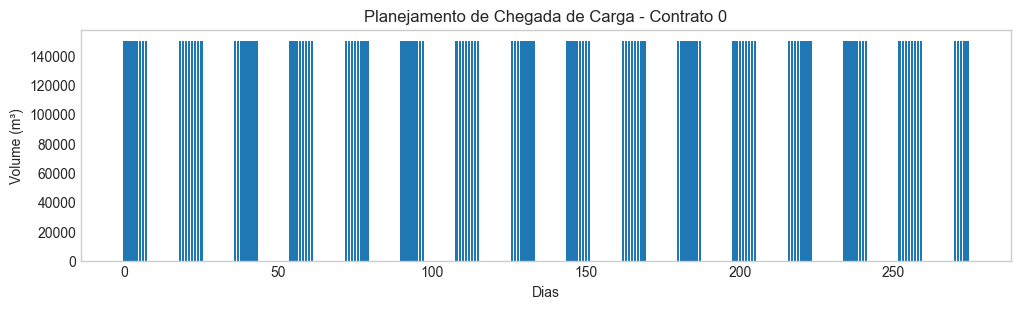

In [152]:
# plot da coluna de planejamento de chegada de carga para o contrato 0 (V_adp_0) ao longo do ano em gráfico de barras
plt.figure(figsize=(12, 3))
plt.bar(entradas_df.index, entradas_df['V_adp_0'])
plt.title('Planejamento de Chegada de Carga - Contrato 0')
plt.xlabel('Dias')
plt.ylabel('Volume (m³)')
plt.grid(False)
plt.show()

O ACQ (V_total) do contrato será o somatório do total planejado no V_adp

O take or pay considera que ao menos 60% desse total deve ser comprado, caso ocntrário, deverá se pagar por carga cancelada mesmo sem receber

O preço possui 2 patamares, com um desconto caso seja comprado mais que 30% do total

In [153]:
V_total = float(entradas_df["V_adp_0"].sum())

V_total*0.6
V_top_lo = [0, V_total*0.6]
V_top_up = [V_total*0.6, V_total]

V_price_lo = [0, V_total*0.3]
V_price_up = [V_total*0.3, V_total]

VT -> V_total  
TPH -> V_top_up  
TPL -> V_top_lo  
LCH -> V_price_up  
LCL -> V_price_lo  
CC_INI -> V_cc_0  
CA_INI -> V_ac_0  



In [154]:
entradas_json["parametros_por_contrato"]["0"] = {
    "theta": theta,
    "P_dem": 1.5e6,
    "V_total": V_total,
    "V_cc_0": 0,
    "V_ca_0": 0,
    "V_top_up": V_top_up, 
    "V_top_lo": V_top_lo,
    "V_price_up": V_price_up,
    "V_price_lo": V_price_lo
}



**Parâmetros de preço**


A equação abaixo demonstra o cálculo básico para a precificação de contratos SPA  
$P_{\text{LNG}} = A \cdot P_{\text{crude oil}} + B$

Será considerado para o cenário o valor do Brent como crude oil index.  
Para o primeiro patamar do LNG pricing A = 10% e B = 0.  
Para o segunto patamar, A = 9% e B = 0  

In [155]:
# Adicionando ao entradas_df a coluna de preço do contrato 0, tier 0 (P_spa_price_0_0) com o valor de brent_crude_oil multiplicado por 13%
entradas_df['P_spa_price_0_0'] = df_price['brent_crude_oil'] * 0.10
# Convertendo esse valor de US$/MMBTU para R$/m³ de GNL usando o valor do dólar e a conversão de MMBTU para m³ de GNL   
entradas_df['P_spa_price_0_0'] = entradas_df['P_spa_price_0_0'] * df_price['dolar_brl'] / M3GNL_MMBTU


# Adicionando ao entradas_df a coluna de preço do contrato 0, tier 1 (P_spa_price_0_1) com o valor de brent_crude_oil multiplicado por 12%
entradas_df['P_spa_price_0_1'] = df_price['brent_crude_oil'] * 0.09
# Convertendo esse valor de US$/MMBTU para R$/m³ de GNL usando o valor do dólar e a conversão de MMBTU para m³ de GNL   
entradas_df['P_spa_price_0_1'] = entradas_df['P_spa_price_0_1'] * df_price['dolar_brl'] / M3GNL_MMBTU

Há também o custo do take or pay que é nulo para o primeiro patamar e acompanha o P_spa_price_0_0 no segundo patamar

In [156]:
entradas_df['P_spa_top_0_0'] = 0
entradas_df['P_spa_top_0_1'] = df_price['brent_crude_oil'] * 0.13

In [157]:
entradas_df.head()

,data,V_d_0,V_d_1,Idle,V_adp_0,N_dem_0,P_spa_price_0_0,P_spa_price_0_1,P_spa_top_0_0,P_spa_top_0_1
0,2024-04-01,0.0,0.0,1,150000.0,0,889.004289,800.103860,0,10.4299
1,2024-04-02,0.0,0.0,1,150000.0,1,901.993285,811.793957,0,10.4299
2,2024-04-03,0.0,0.0,1,150000.0,2,901.315439,811.183895,0,10.4299
3,2024-04-04,0.0,0.0,1,150000.0,3,897.101801,807.391621,0,10.4299
4,2024-04-05,0.0,0.0,1,150000.0,4,892.979764,803.681788,0,10.4299


### Parâmetros do spot

O preço spot considera o valor do spot FOB brazil, que é convertido para R$/m³ de GNL

In [158]:
entradas_df["P_spot"] = df_price["spot_lng_fob_brazil"] * df_price["dolar_brl"] / M3GNL_MMBTU
entradas_df.head()

,data,V_d_0,V_d_1,Idle,V_adp_0,N_dem_0,P_spa_price_0_0,P_spa_price_0_1,P_spa_top_0_0,P_spa_top_0_1,P_spot
0,2024-04-01,0.0,0.0,1,150000.0,0,889.004289,800.103860,0,10.4299,925.238167
1,2024-04-02,0.0,0.0,1,150000.0,1,901.993285,811.793957,0,10.4299,938.756566
2,2024-04-03,0.0,0.0,1,150000.0,2,901.315439,811.183895,0,10.4299,938.051093
3,2024-04-04,0.0,0.0,1,150000.0,3,897.101801,807.391621,0,10.4299,933.665716
4,2024-04-05,0.0,0.0,1,150000.0,4,892.979764,803.681788,0,10.4299,929.375674


Parâmetros de limite de volume para a compra spot   
V_spot_lo = 30000  
V_spot_up = 150000  

In [159]:
entradas_json["parametros_modelo"]["V_spot_lo"] = 30000
entradas_json["parametros_modelo"]["V_spot_up"] = 150000

In [81]:
entradas_json

{'indices': {},
 'conjuntos': {},
 'parametros_modelo': {'S_0': 12000,
  'S_up': 170000,
  'S_idle_lo': 10000,
  'S_prod_lo': 20000,
  'K': 3000000,
  'V_spot_lo': 30000,
  'V_spot_up': 150000},
 'parametros_por_contrato': {'0': {'theta': 8,
   'P_dem': 1500000.0,
   'V_total': 18750000.0,
   'V_cc_0': 0,
   'V_ca_0': 0,
   'V_top_up': [11250000.0, 18750000.0],
   'V_top_lo': [0, 11250000.0],
   'V_price_up': [5625000.0, 18750000.0],
   'V_price_lo': [0, 5625000.0]}}}

### Gráfico dos preços

In [162]:
entradas_df

,data,V_d_0,V_d_1,Idle,V_adp_0,N_dem_0,P_spa_price_0_0,P_spa_price_0_1,P_spa_top_0_0,P_spa_top_0_1,P_spot
0,2024-04-01,0.0,0.0,1,150000.0,0,889.004289,800.103860,0,10.4299,925.238167
1,2024-04-02,0.0,0.0,1,150000.0,1,901.993285,811.793957,0,10.4299,938.756566
2,2024-04-03,0.0,0.0,1,150000.0,2,901.315439,811.183895,0,10.4299,938.051093
3,2024-04-04,0.0,0.0,1,150000.0,3,897.101801,807.391621,0,10.4299,933.665716
4,2024-04-05,0.0,0.0,1,150000.0,4,892.979764,803.681788,0,10.4299,929.375674
...,...,...,...,...,...,...,...,...,...,...,...
270,2024-12-27,0.0,0.0,1,150000.0,0,918.276271,826.448644,0,9.6226,1692.149195
271,2024-12-28,0.0,0.0,1,150000.0,1,918.276271,826.448644,0,9.6226,1692.149195
272,2024-12-29,0.0,0.0,1,150000.0,2,918.276271,826.448644,0,9.6226,1692.149195
273,2024-12-30,0.0,0.0,1,150000.0,3,920.862298,828.776069,0,9.6226,1696.914584


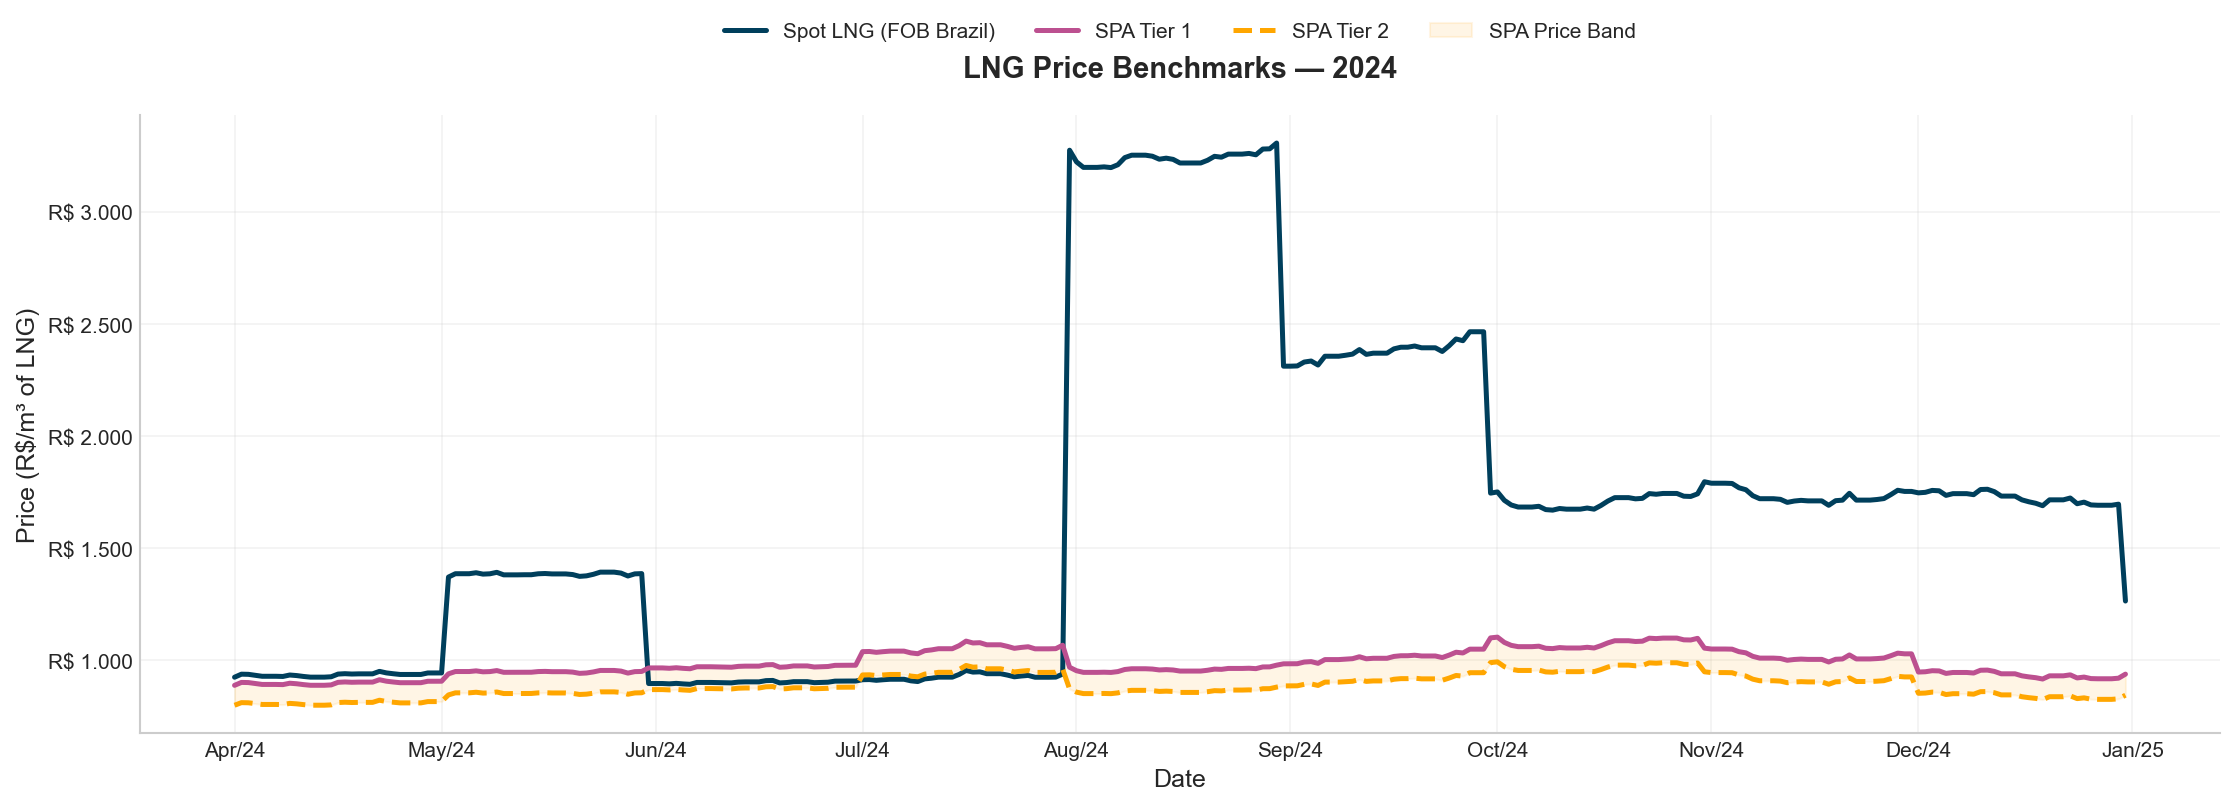

In [170]:
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates

plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(15, 5.5), dpi=150)

dates = entradas_df['data']
spot = entradas_df['P_spot']
spa_tier0 = entradas_df['P_spa_price_0_0']
spa_tier1 = entradas_df['P_spa_price_0_1']
spa_band_lo = np.minimum(spa_tier0, spa_tier1)
spa_band_hi = np.maximum(spa_tier0, spa_tier1)

palette = {
    "spot": "#003f5c",
    "tier0": "#bc5090",
    "tier1": "#ffa600"
}

ax.plot(dates, spot, label='Spot LNG (FOB Brazil)', color=palette['spot'], linewidth=2.4)
ax.plot(dates, spa_tier0, label='SPA Tier 1', color=palette['tier0'], linewidth=2.4)
ax.plot(dates, spa_tier1, label='SPA Tier 2', color=palette['tier1'], linewidth=2.4, linestyle='--')
ax.fill_between(dates, spa_band_lo, spa_band_hi, color=palette['tier1'], alpha=0.10, label='SPA Price Band')

ax.set_title('LNG Price Benchmarks — 2024', fontsize=14, pad=18, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Price (R$/m³ of LNG)', fontsize=12)

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b/%y'))
plt.setp(ax.get_xticklabels(), rotation=0, ha='center')
ax.yaxis.set_major_formatter(FuncFormatter(lambda val, _: f"R$ {val:,.0f}".replace(',', '.')))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(alpha=0.25)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.18), ncol=4, frameon=False)

plt.savefig('saidas/visualizacao_precos_2024.png', dpi=400)
plt.tight_layout()
plt.show()

### Parâmetros gerais

In [83]:
# adicionando valor do dolar ao dataframe entradas_df
entradas_df["ER"] = df_price["dolar_brl"]

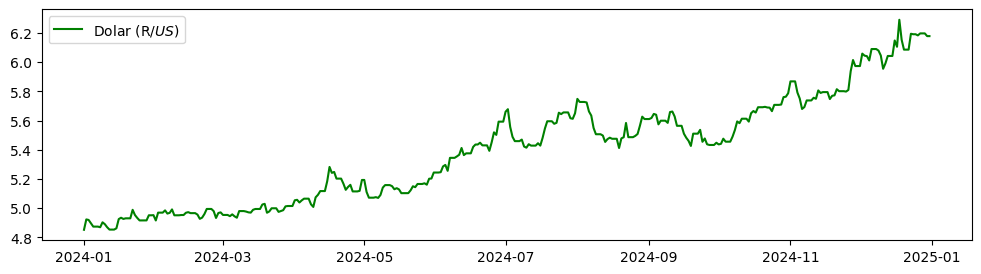

In [84]:
# plot do dolar ao longo do ano
plt.figure(figsize=(12,3))
plt.plot(df_price["index"],df_price["dolar_brl"], label="Dolar (R$/US$)", color='green')
plt.legend()
plt.show()

In [85]:
entradas_df

,data,V_d_0,V_d_1,Idle,V_adp_0,N_dem_0,P_spa_price_0_0,P_spa_price_0_1,P_spa_top_0_0,P_spa_top_0_1,P_spot,ER
0,2024-04-01,0.0,0.0,1,150000.0,0,889.004289,800.103860,0,10.4299,925.238167,4.8526
1,2024-04-02,0.0,0.0,1,150000.0,1,901.993285,811.793957,0,10.4299,938.756566,4.9235
2,2024-04-03,0.0,0.0,1,150000.0,2,901.315439,811.183895,0,10.4299,938.051093,4.9198
3,2024-04-04,0.0,0.0,1,150000.0,3,897.101801,807.391621,0,10.4299,933.665716,4.8968
4,2024-04-05,0.0,0.0,1,150000.0,4,892.979764,803.681788,0,10.4299,929.375674,4.8743
...,...,...,...,...,...,...,...,...,...,...,...,...
270,2024-12-27,0.0,0.0,1,150000.0,0,918.276271,826.448644,0,9.6226,1692.149195,5.4329
271,2024-12-28,0.0,0.0,1,150000.0,1,918.276271,826.448644,0,9.6226,1692.149195,5.4329
272,2024-12-29,0.0,0.0,1,150000.0,2,918.276271,826.448644,0,9.6226,1692.149195,5.4329
273,2024-12-30,0.0,0.0,1,150000.0,3,920.862298,828.776069,0,9.6226,1696.914584,5.4482


## Geração de BOG



| Símbolo | Descrição |
|---------|-----------|
| $\hat{V}^{bog,lo}_{n}$ | Lower inventory bound of BOG interval $n$ (m$^3$) |
| $\hat{V}^{bog,up}_{n}$ | Upper inventory bound of BOG interval $n$ (m$^3$) |
| $\hat{F}^{bog}_{n}$ | Boil-off rate associated with interval $n$ (-) |
| $\hat{V}^{prod}_{bog}$ | BOG generated during regasification (m$^3$/day) |

Seguindo a premissa de 1 tanque menor de 26000 m³ e 3 tanques grandes de 48000 m³, totalizando 170 000 m³ de GNL na FSRU e com uma taxa de geração de BOG de 0.12%, a seguir o cálculo dos patamares de geração de bog

In [86]:
V_small = 26000.
V_big = 48000.

V_bog_lo = [0, V_small, V_big, V_small+V_big, 2*V_big,  V_small+ 2* V_big, 3* V_big]
V_bog_up = [ V_small, V_big, V_small+V_big, 2*V_big,  V_small+ 2* V_big, 3* V_big,  V_small+ 3* V_big]
F_bog = [round(v * 0.0012) for v in V_bog_up]
print(F_bog)


[31, 58, 89, 115, 146, 173, 204]


In [87]:
entradas_json["parametros_modelo"]["V_bog_lo"] = V_bog_lo
entradas_json["parametros_modelo"]["V_bog_up"] = V_bog_up
entradas_json["parametros_modelo"]["F_bog"] = F_bog
entradas_json["parametros_modelo"]["V_bog_prod"] = 100

## Custo financeiro de imobilização de capital

| Símbolo | Descrição |
|---------|-----------|
| $\hat{R}$ | Interest rate used to represent capital cost (-) |
| $\hat{P}^{cap}$ | Reference LNG price for inventory capitalization (R\$/m$^3$) |


O interest rate $\hat{R}$ será baseado em um WACC fictício de 10% aa  
Já para o $\hat{P}^{cap}$ será considerado o menor valor do preço spot para o ano de 2024

In [88]:
R = 0.10

# Conversão da taxa anual para diária considerando juros compostos
def taxa_diaria_juros_compostos(taxa_anual, dias_uteis=252):
    return (1 + taxa_anual) ** (1 / dias_uteis) - 1

entradas_json["parametros_modelo"]["R"] = taxa_diaria_juros_compostos(R)

P_cap = float(entradas_df["P_spot"].min())
entradas_json["parametros_modelo"]["P_cap"] = P_cap

In [89]:
entradas_json

{'indices': {},
 'conjuntos': {},
 'parametros_modelo': {'S_0': 12000,
  'S_up': 170000,
  'S_idle_lo': 10000,
  'S_prod_lo': 20000,
  'K': 3000000,
  'V_spot_lo': 30000,
  'V_spot_up': 150000,
  'V_bog_lo': [0, 26000.0, 48000.0, 74000.0, 96000.0, 122000.0, 144000.0],
  'V_bog_up': [26000.0,
   48000.0,
   74000.0,
   96000.0,
   122000.0,
   144000.0,
   170000.0],
  'F_bog': [31, 58, 89, 115, 146, 173, 204],
  'V_bog_prod': 100,
  'R': 0.0003782865315342665,
  'P_cap': 893.620070426087},
 'parametros_por_contrato': {'0': {'theta': 8,
   'P_dem': 1500000.0,
   'V_total': 18750000.0,
   'V_cc_0': 0,
   'V_ca_0': 0,
   'V_top_up': [11250000.0, 18750000.0],
   'V_top_lo': [0, 11250000.0],
   'V_price_up': [5625000.0, 18750000.0],
   'V_price_lo': [0, 5625000.0]}}}

# Adicionando entradas ao cenário

Adicionando índices

In [90]:
T = len(entradas_df)
I = 2
J = 2
M = 2
C = 2
N = 7

entradas_json["indices"]["T"] = T
entradas_json["indices"]["I"] = I
entradas_json["indices"]["J"] = J
entradas_json["indices"]["M"] = M  
entradas_json["indices"]["C"] = C
entradas_json["indices"]["N"] = N

In [91]:
entradas_json

{'indices': {'T': 275, 'I': 2, 'J': 2, 'M': 2, 'C': 2, 'N': 7},
 'conjuntos': {},
 'parametros_modelo': {'S_0': 12000,
  'S_up': 170000,
  'S_idle_lo': 10000,
  'S_prod_lo': 20000,
  'K': 3000000,
  'V_spot_lo': 30000,
  'V_spot_up': 150000,
  'V_bog_lo': [0, 26000.0, 48000.0, 74000.0, 96000.0, 122000.0, 144000.0],
  'V_bog_up': [26000.0,
   48000.0,
   74000.0,
   96000.0,
   122000.0,
   144000.0,
   170000.0],
  'F_bog': [31, 58, 89, 115, 146, 173, 204],
  'V_bog_prod': 100,
  'R': 0.0003782865315342665,
  'P_cap': 893.620070426087},
 'parametros_por_contrato': {'0': {'theta': 8,
   'P_dem': 1500000.0,
   'V_total': 18750000.0,
   'V_cc_0': 0,
   'V_ca_0': 0,
   'V_top_up': [11250000.0, 18750000.0],
   'V_top_lo': [0, 11250000.0],
   'V_price_up': [5625000.0, 18750000.0],
   'V_price_lo': [0, 5625000.0]}}}

In [92]:
# Adicionando entradas_json em entradas/entradas.json como mais uma entrada chamada "Cen2"

    
with open("entradas/entradas.json", "r", encoding="utf-8") as f:
    dados = json.load(f)
    
dados["Cen2"] = entradas_json

json.dump(dados, open("entradas/entradas.json", "w"), indent=4, ensure_ascii=False)


In [93]:
length = len(entradas_df["data"])

entradas_df["data"] = range(length)

In [94]:
entradas_df

,data,V_d_0,V_d_1,Idle,V_adp_0,N_dem_0,P_spa_price_0_0,P_spa_price_0_1,P_spa_top_0_0,P_spa_top_0_1,P_spot,ER
0,0,0.0,0.0,1,150000.0,0,889.004289,800.103860,0,10.4299,925.238167,4.8526
1,1,0.0,0.0,1,150000.0,1,901.993285,811.793957,0,10.4299,938.756566,4.9235
2,2,0.0,0.0,1,150000.0,2,901.315439,811.183895,0,10.4299,938.051093,4.9198
3,3,0.0,0.0,1,150000.0,3,897.101801,807.391621,0,10.4299,933.665716,4.8968
4,4,0.0,0.0,1,150000.0,4,892.979764,803.681788,0,10.4299,929.375674,4.8743
...,...,...,...,...,...,...,...,...,...,...,...,...
270,270,0.0,0.0,1,150000.0,0,918.276271,826.448644,0,9.6226,1692.149195,5.4329
271,271,0.0,0.0,1,150000.0,1,918.276271,826.448644,0,9.6226,1692.149195,5.4329
272,272,0.0,0.0,1,150000.0,2,918.276271,826.448644,0,9.6226,1692.149195,5.4329
273,273,0.0,0.0,1,150000.0,3,920.862298,828.776069,0,9.6226,1696.914584,5.4482


In [95]:
# Adicionando entradas_df ao entradas/entradas.xlsx como mais uma aba chamada "Cen2"
with pd.ExcelWriter("entradas/entradas.xlsx", mode="a", engine="openpyxl", if_sheet_exists="replace") as writer:
    entradas_df.to_excel(writer, sheet_name="Cen2", index=False)